
<a href="https://colab.research.google.com/github/NeuroDesk/example-notebooks/blob/main/intro_to_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Google Colab"/>   </a>

# Introduction to Preprocessing

Author: Marla Pinkert

This notebook is geared towards people who are taking their **first steps** preprocessing fMRI data and want to learn more, and also towards people who are interested in **teaching** using Neurodesk and want to check out an example to see whether this might be a fit for them. Specifically, we will look at how to deal with **motion**. There will be explanations on what we are doing along the way!

We will use the [NYU Slow Flanker dataset from Openneuro](https://openneuro.org/datasets/ds000102/versions/00001). In this study, healthy adults underwent MRI scanning while performing an event-related [Eriksen Flanker task](https://en.wikipedia.org/wiki/Eriksen_flanker_task).

Objectives:

- Using Neurodesk to access neuroimaging analysis software within Colab
- Understanding Nipype interfaces
- Learning how to do quality checks regarding motion

## Setup Neurodesk
There are many different packages and software used to preprocess MRI data. Installing them locally can be complicated and frustrating. Especially for teaching, when you have to make sure everyone is able install specific software, or as a student, when you are just starting out. We will therefore use Neurodesk to provide us with an environment which already comes with all we need - no complicated set-up.

In [1]:
%%capture
import os
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  os.environ["LD_PRELOAD"] = "";
  os.environ["APPTAINER_BINDPATH"] = "/content,/tmp,/cvmfs"
  os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
  os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

  !curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
  !chmod +x googlecolab_setup.sh
  !./googlecolab_setup.sh

  os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

## Data preparation

In [2]:
# download data
!mkdir /data
%cd /data
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ds000102 && datalad get sub-01

/data
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
Clone attempt:   0% 0.00/2.00 [00:00<?, ? Candidate locations/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0% 0.00/27.0 [00:00<?, ? Objects/s]
                                               
Compressing:   0% 0.00/23.0 [00:00<?, ? Objects/s]
                                                  
Receiving:   0% 0.00/2.15k [00:00<?, ? Objects/s]
                                                 
Resolving:   0% 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] Author identity unknown
| 
| *** Please tell me who you are.
| 
| Run
| 
|   git config --global user.email "you@example.com"
|   git config --global user.name "Your Name"
| 
| to set your account's default identity.
| Omit --global to set the identity only in this repository.
| 
| fatal: unable to auto-detect email address (got 'root@9938e9644327.(no

## FSL and MCFLIRT
**FSL** is a commonly used **library of analysis tools** for fMRI. It has a GUI, but can be used via the command line as well. We can use it for both preprocessing and first- and second-level analysis, however, we will use it for **preprocessing** only. Although you would often combine different tools, so you can cherry pick the best ones, it is completely possible to do every preprocessing step within FSL.

**MCFLIRT** is an FSL tool which we can use for **realigning** our functional data and calculation of **motion parameters**. We can not only run it using the command line, but also via a Nipype interface.

In [3]:
# This enables us to access FSL using Neurodesk
import lmod
await lmod.load('fsl/6.0.4')

# this makes it so FSL knows how we want our output files
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

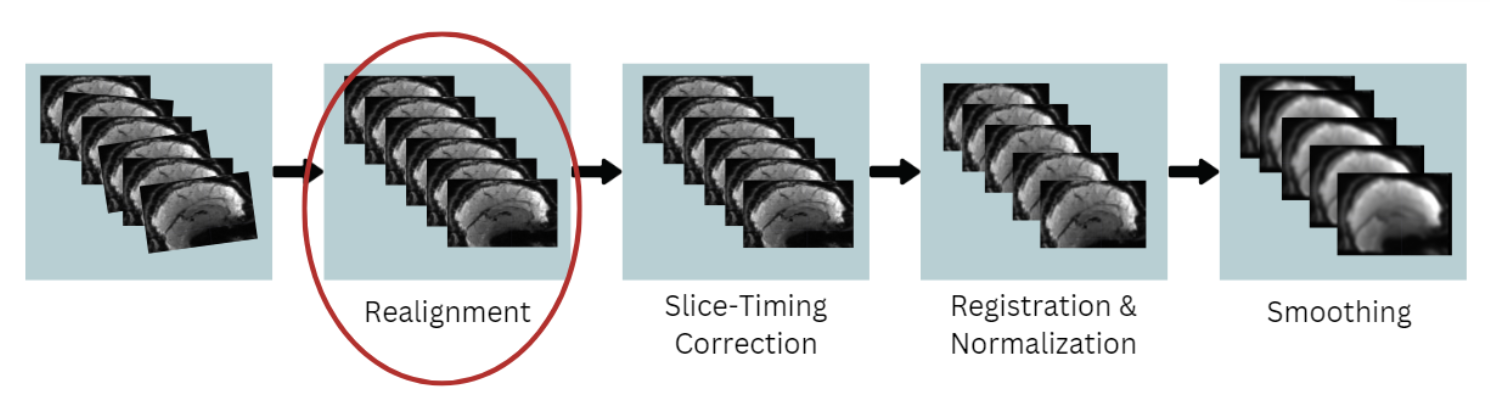

Above, the basic steps of preprocessing a functional file are demonstrated. There is an endless amount of steps to add, and variations in the ordering of the steps. For example, depending how your data was aqcuired, you might want to start **slice-timing correction** before **realignment** (see [here](https://www.fil.ion.ucl.ac.uk/spm/docs/tutorials/fmri/preprocessing/slice_timing/) for more information). However, **smoothing** usually is the last step.

Let's first check which flags the command line tool MCLFLIRT needs:

In [4]:
!mcflirt -help

Usage: mcflirt -in <infile> [options]

  Available options are:
        -out, -o <outfile>               (default is infile_mcf)
        -cost {mutualinfo,woods,corratio,normcorr,normmi,leastsquares}        (default is normcorr)
        -bins <number of histogram bins>   (default is 256)
        -dof  <number of transform dofs>   (default is 6)
        -refvol <number of reference volume> (default is no_vols/2)- registers to (n+1)th volume in series
        -reffile, -r <filename>            use a separate 3d image file as the target for registration (overrides refvol option)
        -scaling <num>                             (6.0 is default)
        -smooth <num>                      (1.0 is default - controls smoothing in cost function)
        -rotation <num>                    specify scaling factor for rotation optimization tolerances
        -verbose <num>                     (0 is least and default)
        -stages <number of search levels>  (default is 3 - specify 4 for final s

Now, we are ready to run **MCFLIRT** on the first run of our first subject. Apart from the inpute file (`in_file`), we specify we want to save the transformation parameters (`-plots`).

In [5]:
# run mcflirt
!mcflirt -in ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz -plots

In the `/func` folder of our first subject, two new files have appeared: `sub-01_task-flanker_run-1_bold_mcf.nii.gz` and `sub-01_task-flanker_run-1_bold_mcf.par`. The NIfTI file is our **realigned** functional file, the .par file contains our **motion parameters**!

## Nipype Interfaces
It is possible to do this exact same thing (using `MCFLIRT`) in Python using a **Nipype** interface. Nipype is an open-source project that allows for integrating a variety of different neuroimaging softwares into a single workflow. Nipype provides "wrappers" (= **interfaces**) for tools and software that is written in other languages than Python.

When we use Nipype, we use the interface **classes** provided by Nipype to instantiate **objects** we can use for analysis.

So, what are objects and classes? One way to think about **classes** is to view them as a sort of construction plan, or blueprint. Imagine a development area in a town where many very similar looking family homes are being built. Usually, these sorts of building projects still offer buyers certain customization options - such as the color, the doors, whether there is a garage. So, the construction plan (class) already contains all the information for building the house, and the custommized houses themselves would then correspond to different **objects** derived fromm the **class**.

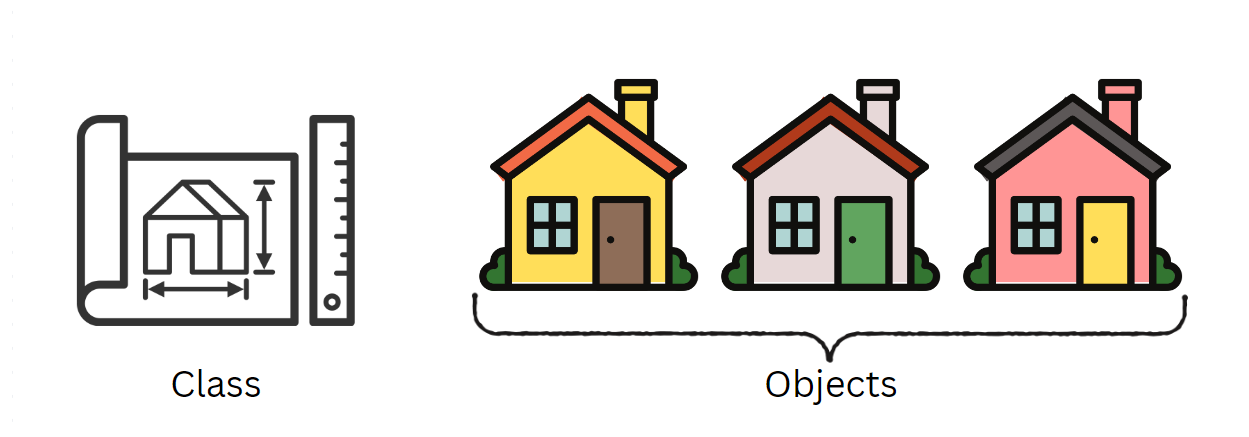

To use `MCFLIRT` via Nipype, we have to import the `MCFLIRT` **class** that wraps the functionality of the tool within Python.

The `nipype.interfaces` module gives us access to many different external tools and software - of course these external tools have to be installed for this to work. You can find a list of all the available packages [here](https://nipype.readthedocs.io/en/latest/api/generated/nipype.interfaces.html).

For `MCFLIRT`, we will import the `fsl` module.

In [6]:
from nipype.interfaces import fsl

First, let's have a look at the docstring of the ```MCFLIRT``` class:

In [7]:
help(fsl.MCFLIRT)

Help on class MCFLIRT in module nipype.interfaces.fsl.preprocess:

class MCFLIRT(nipype.interfaces.fsl.base.FSLCommand)
 |  MCFLIRT(**inputs)
 |  
 |  FSL MCFLIRT wrapper for within-modality motion correction
 |  
 |  For complete details, see the `MCFLIRT Documentation.
 |  <https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MCFLIRT>`_
 |  
 |  Examples
 |  --------
 |  >>> from nipype.interfaces import fsl
 |  >>> mcflt = fsl.MCFLIRT()
 |  >>> mcflt.inputs.in_file = 'functional.nii'
 |  >>> mcflt.inputs.cost = 'mutualinfo'
 |  >>> mcflt.inputs.out_file = 'moco.nii'
 |  >>> mcflt.cmdline
 |  'mcflirt -in functional.nii -cost mutualinfo -out moco.nii'
 |  >>> res = mcflt.run()  # doctest: +SKIP
 |  
 |  Method resolution order:
 |      MCFLIRT
 |      nipype.interfaces.fsl.base.FSLCommand
 |      nipype.interfaces.base.core.CommandLine
 |      nipype.interfaces.base.core.BaseInterface
 |      nipype.interfaces.base.core.Interface
 |      builtins.object
 |  
 |  Data and other attributes defined h

The first step when using interfaces is always to create an **object** (or: instance) of the respective interface **class** (in this case the `MCFLIRT` class). We will also specify input and output file, and that we want to "`save_plots`" - remember how this relates to the `-plots` flag we used before.

In [8]:
moco = fsl.MCFLIRT(in_file = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz", out_file = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_mfc.nii.gz",save_plots=True)

One attribute that you can find for almost every Nipype interface is ```cmdline```. It refers to the command that will be run on our computer. Nipype interfaces are just wrappers - "under the hood", the external non-Python software will run.

If you run into errors with your code, you can try to run this command directly in the command line. Sometimes, that helps to figure out what the issue is.

In [9]:
print(moco.cmdline)

mcflirt -in ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz -out ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_mfc.nii.gz -plots


Now that we have instantiated our `MCFLIRT` object and provided the needed inputs, we can go ahead and run the interface using the `run()` method. This procedure is common to almost all Nipype interfaces:
1. instanstiate the object of a specific interface class
2. provide mandatory and optional inputs
3. run it by using the `run` method.

In [10]:
moco_res = moco.run()

By saving the result of running our object, we can easily access the `outputs` attribute. This is helpful if we forget were we saved our files ;).

In [11]:
moco_res.outputs


mat_file = <undefined>
mean_img = <undefined>
out_file = /data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_mfc.nii.gz
par_file = /data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_mfc.nii.gz.par
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>

## Plotting Motion Parameters
Now that we calculated our motion parameters, we can get to **plotting** them. First, we load them into memory using numpy, and have a look at their **shape**.

In [12]:
import numpy as np

motion_path = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_mcf.par"
motion_parameters = np.loadtxt(motion_path)
print(f"Shape of motion parameter matrix: {motion_parameters.shape}")

Shape of motion parameter matrix: (146, 6)


A quick look at the shape of our array reveals that there are 146 timepoints and 6 parameters per timepoint. These 6 parameters concern 3 directions (**x, y, and z**) - the **translation**, and 3 angles in which the head can rotate (**pitch, yaw, and roll**) - the **rotation**.

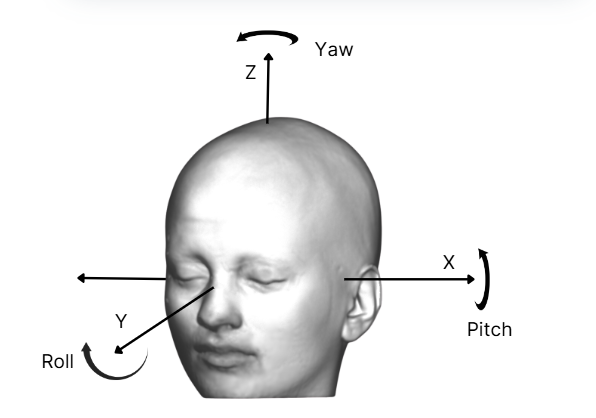

Let's have a look at the first 10 timepoints, and how they are represented in an array.

In [13]:
motion_parameters[:10,:]

array([[-0.00273076, -0.00276311, -0.00237603, -0.154286  ,  0.011919  ,
         0.0328879 ],
       [-0.00298859, -0.00262473, -0.00237603, -0.15885   ,  0.0274672 ,
         0.0875287 ],
       [-0.0029029 , -0.00255196, -0.00224164, -0.166514  ,  0.0269606 ,
         0.0997821 ],
       [-0.00252297, -0.00276311, -0.00237603, -0.166644  ,  0.0142047 ,
         0.0871495 ],
       [-0.00240446, -0.00270943, -0.00237603, -0.168801  , -0.00752524,
         0.0624465 ],
       [-0.00274884, -0.00258874, -0.00237603, -0.172638  ,  0.0512277 ,
         0.116354  ],
       [-0.00256525, -0.00251282, -0.00203235, -0.15235   , -0.0108426 ,
         0.0804987 ],
       [-0.00228808, -0.00276311, -0.00200398, -0.163281  ,  0.00232863,
         0.0529415 ],
       [-0.00252837, -0.00250916, -0.00224777, -0.165916  ,  0.00128811,
         0.0960623 ],
       [-0.00249458, -0.00276311, -0.00237603, -0.161301  ,  0.00757243,
         0.0870456 ]])

We now create two plots - the first one using the x, y, and z parameters, the second one using the pitch, yaw, and roll parameters. As you were able to see above, there are no labels to these arrays which tell us which parameter is which. This doesn't matter, as their order is always x, y, z, pitch, yaw, and roll

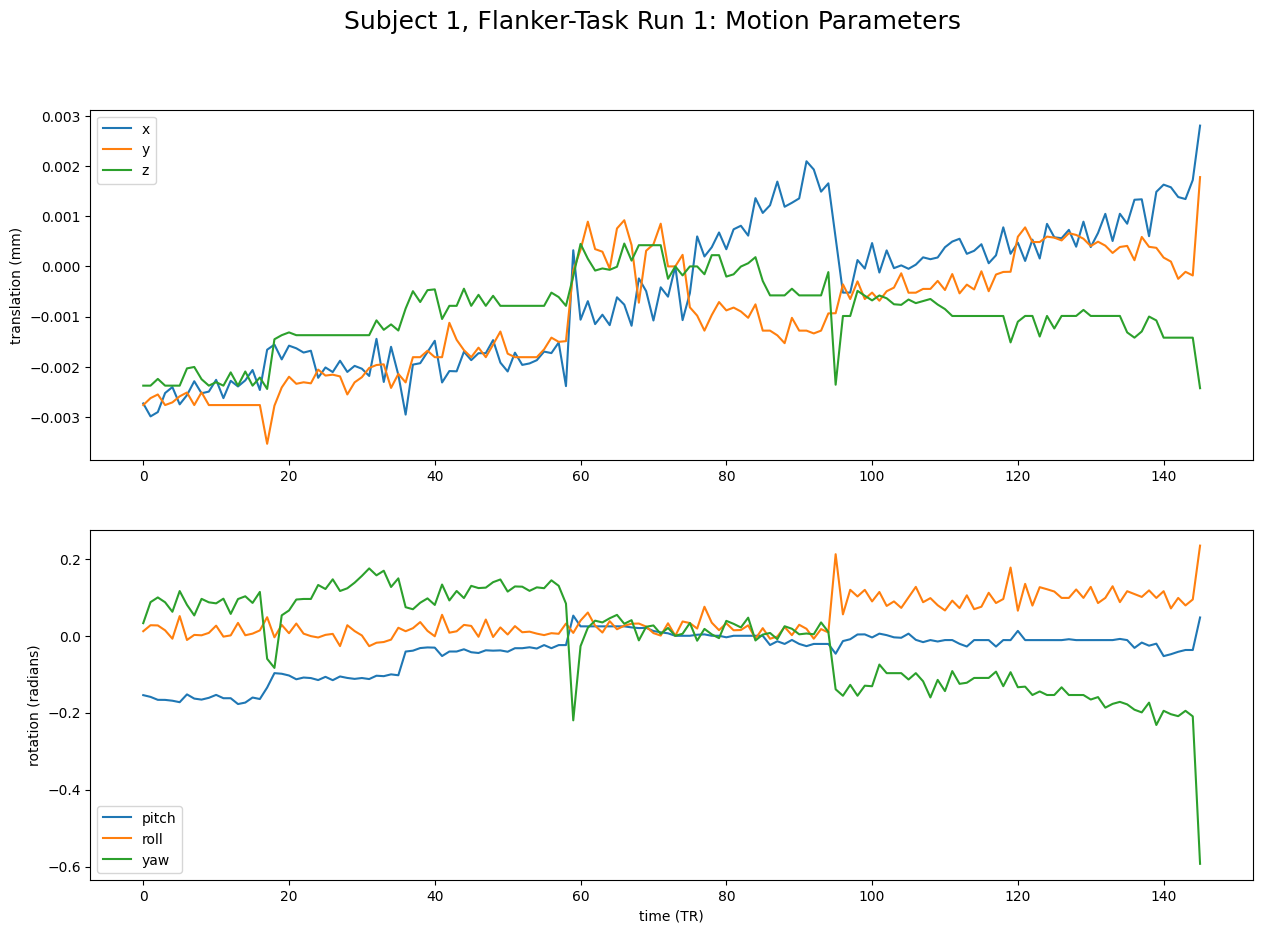

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

# Create plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

# Plot motion parameters
axes[0].plot(motion_parameters[:, :3]) # x, y, z
axes[1].plot(motion_parameters[:, 3:]) # pitch, roll, yaw

# Add labels
axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x","y","z"])
axes[1].legend(["pitch","roll","yaw"])

# Add main figure title
fig.suptitle(f"Subject 1, Flanker-Task Run 1: Motion Parameters",fontsize = 18)

plt.show()

Sometimes, we might introduce motion due to our task. If you like to check whether this is true for your data, it may make sense to check by plotting the timings of the task.

Text(0.5, 0.98, 'Subject 1, Flanker-Task Run 1: Motion Parameters')

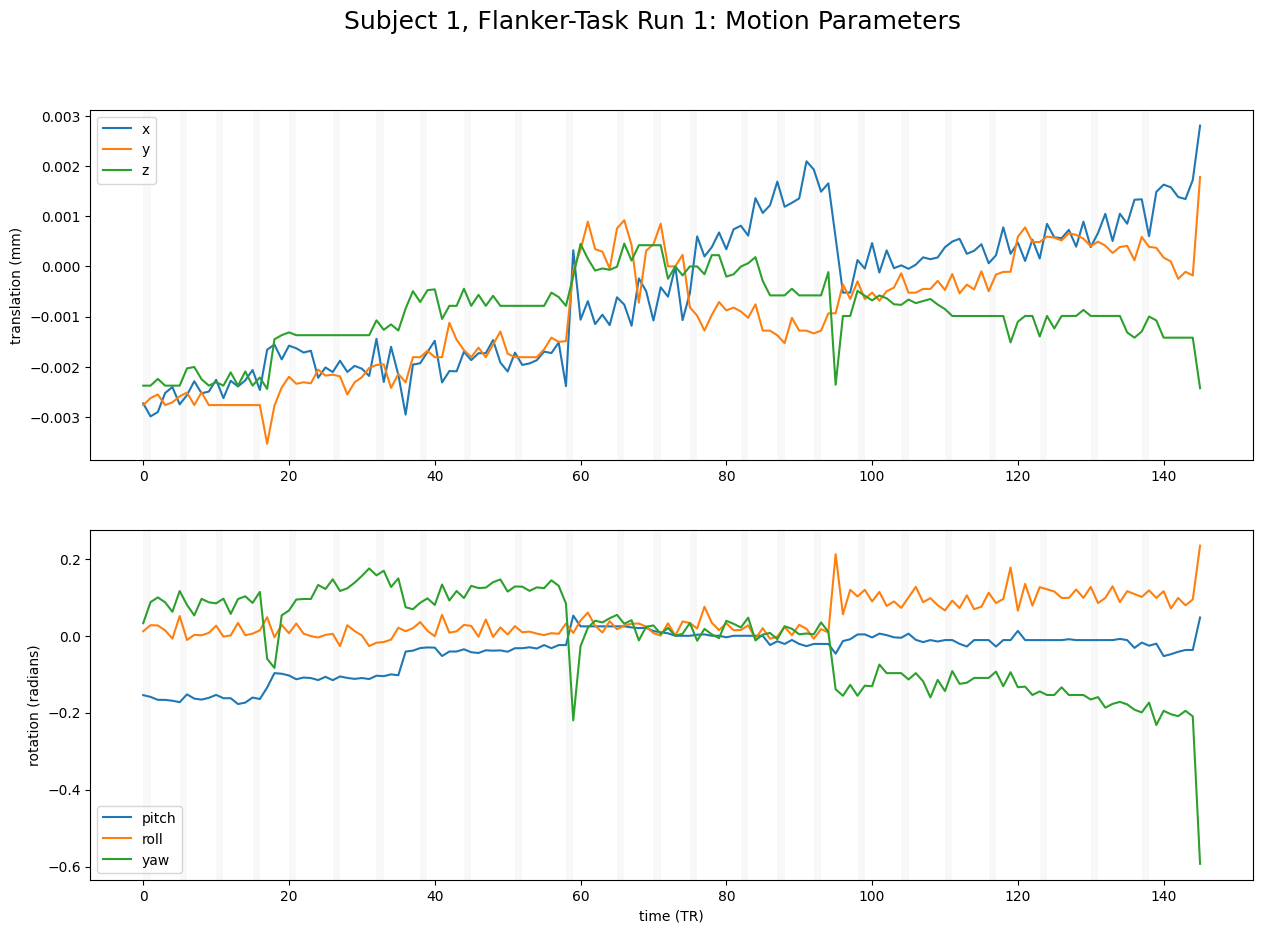

In [15]:
# Read in events
import pandas as pd
events_path = "/data/ds000102/sub-01/func/sub-01_task-flanker_run-1_events.tsv"
events = pd.read_csv(events_path, sep = '\t')

# get timings of task onset and offset
task_on = events["onset"]
task_off = events["duration"]

# Divide by TR
task_on_tr = (task_on/2).tolist()
task_off_tr = ((task_on + task_off)/2).tolist()

# Create plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15,10))

# Plot motion parameters
axes[0].plot(motion_parameters[:, :3]) # x, y, z
axes[1].plot(motion_parameters[:, 3:]) # pitch, roll, yaw

# Plot effort blocks
for motion_on, motion_off in zip(task_on_tr, task_off_tr):
    axes[0].axvspan(motion_on, motion_off, color='grey', alpha=0.05, lw=0)

for motion_on, motion_off in zip(task_on_tr, task_off_tr):
    axes[1].axvspan(motion_on, motion_off, color='grey', alpha=0.05, lw=0)


# Add labels to plots
axes[0].set_ylabel("translation (mm)")
axes[1].set_ylabel("rotation (radians)")
axes[1].set_xlabel("time (TR)")

axes[0].legend(["x","y","z"])
axes[1].legend(["pitch","roll","yaw"])

# Add main figure title
fig.suptitle(f"Subject 1, Flanker-Task Run 1: Motion Parameters",fontsize = 18)

A student in my class had the idea to plot the motion parameters in 3D space, which I thought was fun. See below:

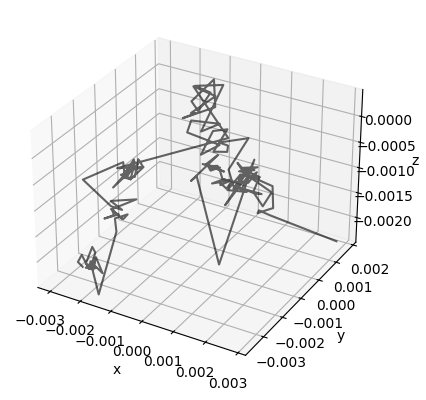

In [16]:
ax = plt.axes(projection="3d")

# Plot movement
ax.plot3D(motion_parameters[:, 0], motion_parameters[:, 1], motion_parameters[:, 2], color = "black", alpha = 0.6)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

plt.show()

## Additional Motion Parameters

So far, we have inspected all motion parameters visually. That is an important part of figuring out whether our participants moved too much. However, we can also calculate additional parameters. We will use `fsl.MotionOutliers`, which is a wrapper for the FSL tool `fsl_motion_outliers`, to calculate **mean & maximum framewise displacement**, as well as **outliers**. See [here](https://nipype.readthedocs.io/en/0.12.1/interfaces/generated/nipype.interfaces.fsl.utils.html#motionoutliers) for the documentation.

We start with instantiating our object with the necessary parameters.

In [17]:
mo = fsl.MotionOutliers(
    in_file = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz",
    metric = "fdrms",
    out_metric_values = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_fdrms.par",
    out_file = "ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_outliers.txt"
)

We check what the command for the command line looks like:

In [18]:
print(mo.cmdline)

fsl_motion_outliers -i ds000102/sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz --fdrms -o ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_outliers.txt -p sub-01_task-flanker_run-1_bold_metrics.png -s ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_fdrms.par


An we run our object!

In [19]:
res = mo.run()

Let's check which outputs we got:

In [20]:
res.outputs


out_file = /data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_outliers.txt
out_metric_plot = /data/sub-01_task-flanker_run-1_bold_metrics.png
out_metric_values = /data/ds000102/sub-01/func/sub-01_task-flanker_run-1_bold_fdrms.par

Now we can look at mean and maximum famewise displacement as well as outliers!

In [21]:
fdrms = np.loadtxt(res.outputs.out_metric_values )
outlier = np.loadtxt(res.outputs.out_file)

print(f"There is a maximum framewise displacement of {np.max(fdrms)} mm.")
print(f"There is a mean framewise displacement of {np.mean(fdrms)} mm.")
print(f"{round(np.sum(outlier)/len(outlier)*100,2)}% of timepoints are outliers.")

There is a maximum framewise displacement of 0.439103 mm.
There is a mean framewise displacement of 0.05534307294520548 mm.
6.16% of timepoints are outliers.
